In [55]:
import gc
import torch
import torchaudio
import librosa
import keras
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import warnings

tqdm.pandas()

# suppress all warnings
warnings.filterwarnings("ignore")

In [56]:
RATE_HZ = 16000 # resampling rate in Hz
MAX_LENGTH = 128000 # maximum audio interval length to consider (= RATE_HZ * SECONDS)
CSV_FILE_PATH: str = "bio_metadata.csv"
NATIVE_FILE_PATH: str = "native_bio_metadata.csv"
ALL_SPEAKERS_PATH: str = "speakers_all.csv"
NON_NATIVE_FILE_PATH: str = "non_native_bio_metadata.csv"
COL_SIZE: int = 30
SILENCE_THRESHOLD: float = .01
RATE: int = 2400
N_MFCC: int = 13

In [57]:
# extract acoustic features from audio files function
def extract_mfcc_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=N_MFCC)
        mfccs_processed = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    return mfccs_processed

# extract, chroma_stft, spectral_centroid, 
# spectral_bandwidth, spectral_rolloff, zero_crossing_rate function
def extract_accoustic_features(file_name):
    """
        Extracts accoustic features from audio file
        Takes in the file name and returns the following features:
        Args:
            :param file_name: str: name of the file to extract features from
        Returns:
            :return mfcc: np.array: Mel-frequency cepstral coefficients
            :return chroma_stft: np.array: Chroma short-time Fourier transform
            :return spectral_centroid: np.array: Spectral centroid
            :return spectral_bandwidth: np.array: Spectral bandwidth
            :return spectral_rolloff: np.array: Spectral rolloff
            :return zero_crossing_rate: np.array: Zero crossing rate
    """
    try:
        audio, sample_rate = librosa.load(f'./data/audio/{file_name}')
        mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=COL_SIZE).T, axis=0)
        chroma_stft = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sample_rate).T, axis=0)
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sample_rate).T, axis=0)
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sample_rate).T, axis=0)
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(audio).T, axis=0)
        return mfcc, chroma_stft, spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    

# extract pitch intensity, duration, loudness, jitter, shimmer, hnr function (prosodic features)
def extract_prosodic_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        pitch_intensity = np.mean(librosa.pyin.piptrack(y=audio, sr=sample_rate).T, axis=0)
        duration = np.mean(librosa.effects.time_stretch(audio, 1.0).T, axis=0)
        loudness = np.mean(librosa.feature.rms(y=audio).T, axis=0)
        jitter = np.mean(librosa.effects.jitter(y=audio).T, axis=0)
        shimmer = np.mean(librosa.effects.shimmer(y=audio).T, axis=0)
        hnr = np.mean(librosa.effects.harmonic(y=audio).T, axis=0)
        return pitch_intensity, duration, loudness, jitter, shimmer, hnr
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    

# extract plp features function
def extract_plp_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        plp = np.mean(librosa.beat.plp(y=audio, sr=sample_rate, n_mfcc=COL_SIZE).T, axis=0)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    return plp

In [58]:
# get wav from file function
def get_wav(file_name):
    try:
        audio, sample_rate = librosa.load(f'./data/audio/{file_name}.wav')
        return librosa.core.resample(y=audio, orig_sr=sample_rate, target_sr=RATE, scale=True)
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None

# convert wave to mfcc function
def wave_to_mfcc(audio, sample_rate):
    try:
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=N_MFCC)
        mfccs_processed = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print("Error encountered while parsing audio")
        return None
    return mfccs_processed

# normalize mfcc function
def normalize_mfcc(mfcc):
    mms = MinMaxScaler()
    return mms.fit_transform(np.abs(mfcc))

# to categorical function
def to_categorical(y):
    lang_dict = {}
    for index, language in enumerate(set(y)):
        lang_dict[language] = index
    y = list(map(lambda x: lang_dict[x],y))
    return keras.utils.to_categorical(y, len(lang_dict)), lang_dict


In [59]:
# load the native_bio_metadata.csv
native_bio_metadata = pd.read_csv(NATIVE_FILE_PATH)
native_bio_metadata.head()

,href,language_num,sex,birth_place,native_language,other_languages,age_sex,age_of_english_onset,english_learning_method,english_residence,length_of_english_residence,age
0,http://accent.gmu.edu/browse_language.php?func...,mandarin1,female,"['shanxi,', 'china']",mandarin\n(cmn),['none'],"['26,', 'female', '']",13.0,academic,usa,2.0,26.0
1,http://accent.gmu.edu/browse_language.php?func...,mandarin2,female,"['nanjing,', 'china']",mandarin\n(cmn),"['japanese', '']","['38,', 'female', '']",14.0,academic,usa,0.8,38.0
2,http://accent.gmu.edu/browse_language.php?func...,mandarin3,male,"['jilin,', 'china']",mandarin\n(cmn),"['italian', 'german', 'french', '']","['43,', 'male', '']",10.0,academic,usa,14.0,43.0
3,http://accent.gmu.edu/browse_language.php?func...,mandarin4,female,"['shanghai,', 'china']",mandarin\n(cmn),"['japanese', '']","['24,', 'female', '']",6.0,academic,usa,1.0,24.0
4,http://accent.gmu.edu/browse_language.php?func...,mandarin5,female,"['beijing,', 'china']",mandarin\n(cmn),['none'],"['31,', 'female', '']",12.0,academic,usa,2.0,31.0


In [60]:
# drop href, age_sex, age_of_english_onset, other_languages, birthplace
native_bio_metadata.drop(columns=['href', 'age', 'age_of_english_onset', 'other_languages', 'birth_place', 'age_sex', 'length_of_english_residence', 'english_learning_method'], inplace=True)
native_bio_metadata.head()

,language_num,sex,native_language,english_residence
0,mandarin1,female,mandarin\n(cmn),usa
1,mandarin2,female,mandarin\n(cmn),usa
2,mandarin3,male,mandarin\n(cmn),usa
3,mandarin4,female,mandarin\n(cmn),usa
4,mandarin5,female,mandarin\n(cmn),usa


In [61]:
# describe the native_bio_metadata
native_bio_metadata.describe()

,language_num,sex,native_language,english_residence
count,1224,1224,1224,1224
unique,1169,2,27,3
top,english578,female,english\n(eng),usa
freq,3,635,604,1031


In [62]:
# remove \n and select first one in native_bio_metadata['english_residence']
native_bio_metadata['english_residence'] = native_bio_metadata['english_residence'].apply(lambda x: x.split('\n')[0])
native_bio_metadata.sample(10)

,language_num,sex,native_language,english_residence
456,english234,male,english\n(eng),usa
454,english231,male,english\n(eng),usa
851,german14,female,german\n(deu),usa
73,mandarin117,male,mandarin\n(cmn),usa
101,mandarin145,female,mandarin\n(cmn),usa
728,english600,female,english\n(eng),usa
2,mandarin3,male,mandarin\n(cmn),usa
795,french4,female,french\n(fra),usa
150,arabic47,male,arabic\n(acw),usa
229,arabic135,female,arabic\n(ars),usa


In [63]:
# value counts
native_bio_metadata['english_residence'].value_counts()

english_residence
usa       1031
uk         115
canada      78
Name: count, dtype: int64

In [64]:
native_bio_metadata.shape

(1224, 4)

In [65]:
# to categorical function
def to_categorical(y):
    lang_dict = {}
    for index, language in enumerate(set(y)):
        lang_dict[language] = index
    y = list(map(lambda x: lang_dict[x],y))
    return keras.utils.to_categorical(y, len(lang_dict)), lang_dict

In [66]:
# add a new column 'file' with the full path of the audio file, the audio files are location in './data/native_combined/'
native_bio_metadata.loc[:, 'file'] = native_bio_metadata['language_num'].apply(lambda x: f"data/audio/{x}.wav")
native_bio_metadata.head()

,language_num,sex,native_language,english_residence,file
0,mandarin1,female,mandarin\n(cmn),usa,data/audio/mandarin1.wav
1,mandarin2,female,mandarin\n(cmn),usa,data/audio/mandarin2.wav
2,mandarin3,male,mandarin\n(cmn),usa,data/audio/mandarin3.wav
3,mandarin4,female,mandarin\n(cmn),usa,data/audio/mandarin4.wav
4,mandarin5,female,mandarin\n(cmn),usa,data/audio/mandarin5.wav


In [67]:
native_bio_metadata['english_residence'].value_counts()

english_residence
usa       1031
uk         115
canada      78
Name: count, dtype: int64

In [68]:
def get_transform_audio(file):
    audio,rate = torchaudio.load(str(file))
    transform = torchaudio.transforms.Resample(rate,RATE_HZ)
    audio = transform(audio).squeeze(0).numpy()
    audio = audio[:MAX_LENGTH] # truncate to first part of audio to save RAM
    return audio

In [69]:
native_bio_metadata['audio'] = native_bio_metadata['file'].progress_apply(get_transform_audio)

100%|██████████| 1224/1224 [00:39<00:00, 31.36it/s]


In [70]:
native_bio_metadata['english_residence'].value_counts()

english_residence
usa       1031
uk         115
canada      78
Name: count, dtype: int64

In [71]:
native_bio_metadata.sample(5)

,language_num,sex,native_language,english_residence,file,audio
783,dutch42,male,dutch\n(nld),usa,data/audio/dutch42.wav,"[-1.8579225e-06, 0.00020130296, 9.2594564e-05,..."
735,english619,male,english\n(eng),usa,data/audio/english619.wav,"[-0.0005675007, -0.0010655421, -0.0012509344, ..."
1106,english566,male,english\n(eng),uk,data/audio/english566.wav,"[1.1244612e-06, -2.3037837e-06, -8.9388544e-07..."
412,english182,male,english\n(eng),usa,data/audio/english182.wav,"[0.0015374287, 0.004290488, 0.0029551073, 0.00..."
749,english634,male,english\n(eng),usa,data/audio/english634.wav,"[-3.8950684e-06, -1.5012563e-06, 1.4515209e-05..."


In [72]:
X = native_bio_metadata['language_num'].values
y = native_bio_metadata['english_residence'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((979,), (245,), (979,), (245,))

In [73]:
# create a counter for train and test labels
train_counter = Counter(y_train)
test_counter = Counter(y_test)

print(f"Train Count: {train_counter}")
print(f"Test Count: {test_counter}")

Train Count: Counter({'usa': 825, 'uk': 92, 'canada': 62})
Test Count: Counter({'usa': 206, 'uk': 23, 'canada': 16})


In [74]:
y_train_cat, _ = to_categorical(y_train)
y_test_cat, lang_dict = to_categorical(y_test)

In [75]:
lang_dict

{'uk': 0, 'canada': 1, 'usa': 2}

In [76]:
X_train[0]

'korean17'

In [77]:
# extract acoustic features
X_train_acoustic = []

for audio in X_train:
    # audio is a waveform, load it and extract the features
    # mfcc, chroma_stft, spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate
    mfcc, chroma_stft, _, _, _, _ = extract_accoustic_features(audio + '.wav')
    
    X_train_acoustic.append([
        mfcc, 
        chroma_stft,
    ])

In [78]:
X_train_acoustic[0]

[array([-2.9854788e+02,  1.0018929e+02,  1.4021946e+01,  3.4105389e+01,
         2.6978836e+01,  2.5779548e+00, -1.7251490e+01, -3.7422760e+00,
        -2.8933690e+00, -1.2154477e+00, -7.6600394e+00,  3.2130060e+00,
        -3.9190469e+00, -5.9488559e+00, -7.2189875e-02, -4.2457094e+00,
        -3.6969032e+00, -3.5017710e+00, -6.7509122e+00,  2.1841373e+00,
        -7.7280364e+00, -1.6519161e+00, -1.0259559e+00, -4.7938318e+00,
        -8.8447064e-01, -9.8065269e-01, -1.3188778e+00, -8.3237255e-01,
         2.6794475e-01, -5.1401299e-01], dtype=float32),
 array([0.47957304, 0.48747405, 0.4527374 , 0.4049991 , 0.36108834,
        0.30341405, 0.3093493 , 0.3299393 , 0.3568159 , 0.43707561,
        0.49750644, 0.5231391 ], dtype=float32)]

In [79]:
X_test_acoustic = []

for file in X_test:
    audio = file
    mfcc, chroma_stft, _, _, _, _ = extract_accoustic_features(audio + '.wav')
    X_test_acoustic.append([
        mfcc,
        chroma_stft,
    ])

In [80]:
X_train_acoustic[0]

[array([-2.9854788e+02,  1.0018929e+02,  1.4021946e+01,  3.4105389e+01,
         2.6978836e+01,  2.5779548e+00, -1.7251490e+01, -3.7422760e+00,
        -2.8933690e+00, -1.2154477e+00, -7.6600394e+00,  3.2130060e+00,
        -3.9190469e+00, -5.9488559e+00, -7.2189875e-02, -4.2457094e+00,
        -3.6969032e+00, -3.5017710e+00, -6.7509122e+00,  2.1841373e+00,
        -7.7280364e+00, -1.6519161e+00, -1.0259559e+00, -4.7938318e+00,
        -8.8447064e-01, -9.8065269e-01, -1.3188778e+00, -8.3237255e-01,
         2.6794475e-01, -5.1401299e-01], dtype=float32),
 array([0.47957304, 0.48747405, 0.4527374 , 0.4049991 , 0.36108834,
        0.30341405, 0.3093493 , 0.3299393 , 0.3568159 , 0.43707561,
        0.49750644, 0.5231391 ], dtype=float32)]

In [81]:
# create pytorch model to train the data on
class AcousticDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Concatenate the features within each sample
        features = torch.tensor(np.concatenate(self.X[idx], axis=0), dtype=torch.float32)
        label = torch.tensor(self.y[idx], dtype=torch.long)  # self.y[idx] is the label index
        return features, label

In [82]:
train_dataset = AcousticDataset(X_train_acoustic, y_train_cat)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [83]:
# create the data loaders
val_dataset = AcousticDataset(X_test_acoustic, y_test_cat)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [84]:
# Get the dimension of the input feature
# input_dim = train_dataset[0][0].shape[0] + train_dataset[0][1].shape[0]

input_dim = 42

# Adjust the first linear layer to match the input size
# model = nn.Sequential(
#     nn.Linear(input_dim, 128),  # Change this to match input size
#     nn.ReLU(),
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, 32),
#     nn.ReLU(),
#     nn.Linear(32, len(lang_dict))
# )

model = nn.Sequential(
    nn.Linear(input_dim, 128),  # Change this to match input size 8, 16, 32, 64, 128, 256, 512, 1024, 2048
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, len(lang_dict))
)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [85]:
# Train the model
n_epochs = 300
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        # print(target)
        target_indices = torch.argmax(target, dim=1)
        # data = data.unsqueeze(1)
        # Assuming data has shape (batch_size, 42)
        output = model(data)
        loss = criterion(output, target_indices)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    for data, target in val_loader:
        target_indices = torch.argmax(target, dim=1)
        # data = data.unsqueeze(1)
        output = model(data)
        loss = criterion(output, target_indices)
        val_loss += loss.item() * data.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")


Epoch 1/300 Train Loss: 0.6720 Val Loss: 0.5482
Epoch 2/300 Train Loss: 0.5471 Val Loss: 0.5723
Epoch 3/300 Train Loss: 0.5567 Val Loss: 0.5327
Epoch 4/300 Train Loss: 0.5341 Val Loss: 0.5377
Epoch 5/300 Train Loss: 0.5436 Val Loss: 0.5229
Epoch 6/300 Train Loss: 0.5411 Val Loss: 0.5187
Epoch 7/300 Train Loss: 0.5589 Val Loss: 0.5877
Epoch 8/300 Train Loss: 0.5386 Val Loss: 0.5285
Epoch 9/300 Train Loss: 0.5277 Val Loss: 0.5401
Epoch 10/300 Train Loss: 0.5306 Val Loss: 0.5163
Epoch 11/300 Train Loss: 0.5305 Val Loss: 0.5258
Epoch 12/300 Train Loss: 0.5319 Val Loss: 0.5294
Epoch 13/300 Train Loss: 0.5402 Val Loss: 0.5213
Epoch 14/300 Train Loss: 0.5275 Val Loss: 0.5163
Epoch 15/300 Train Loss: 0.5284 Val Loss: 0.5172
Epoch 16/300 Train Loss: 0.5552 Val Loss: 0.5642
Epoch 17/300 Train Loss: 0.5407 Val Loss: 0.5413
Epoch 18/300 Train Loss: 0.5321 Val Loss: 0.5217
Epoch 19/300 Train Loss: 0.5261 Val Loss: 0.5331
Epoch 20/300 Train Loss: 0.5277 Val Loss: 0.5285
Epoch 21/300 Train Loss: 0.54

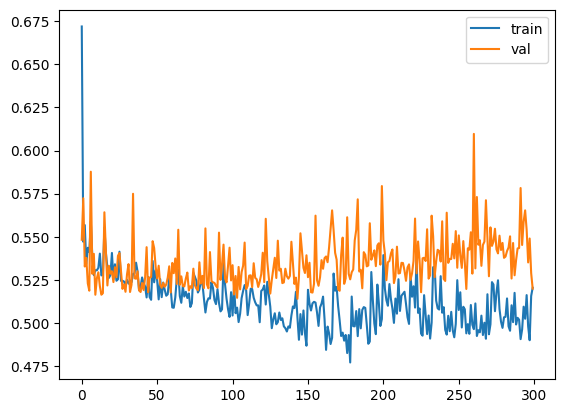

In [86]:
# plot the training and validation loss
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()


In [87]:
# get the accuracy of the model
correct = 0
total = 0
with torch.no_grad():
    for data, target in val_loader:
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target_indices).sum().item()
        
print(f"Accuracy: {correct / total:.2f}")

Accuracy: 0.84


In [88]:
class AudioClassifier(nn.Module):
    def __init__(self, input_size=42, num_classes=len(lang_dict)):
        super(AudioClassifier, self).__init__()
        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            # nn.BatchNorm1d(32),
            nn.Conv1d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Conv1d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2),
            nn.ReLU(),
            # nn.BatchNorm1d(256),
        )
        # Wrap the Linear Blocks
        self.linear = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.mean(-1)
        x = self.linear(x)
        return x
    
model = AudioClassifier()
summary(model, (42,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 32, 20]             128
              ReLU-2               [-1, 32, 20]               0
            Conv1d-3                [-1, 64, 9]           6,208
              ReLU-4                [-1, 64, 9]               0
            Conv1d-5               [-1, 128, 4]          24,704
              ReLU-6               [-1, 128, 4]               0
            Conv1d-7               [-1, 256, 1]          98,560
              ReLU-8               [-1, 256, 1]               0
            Linear-9                  [-1, 128]          32,896
             ReLU-10                  [-1, 128]               0
           Linear-11                   [-1, 64]           8,256
             ReLU-12                   [-1, 64]               0
           Linear-13                    [-1, 3]             195
Total params: 170,947
Trainable params:

In [89]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, )

# adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train the model
n_epochs = 300
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        loss = criterion(output, target_indices)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    for data, target in val_loader:
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        loss = criterion(output, target_indices)
        val_loss += loss.item() * data.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")


Epoch 1/300 Train Loss: 0.7661 Val Loss: 0.6025
Epoch 2/300 Train Loss: 0.5531 Val Loss: 0.5416
Epoch 3/300 Train Loss: 0.5398 Val Loss: 0.5399
Epoch 4/300 Train Loss: 0.5385 Val Loss: 0.5393
Epoch 5/300 Train Loss: 0.5371 Val Loss: 0.5373
Epoch 6/300 Train Loss: 0.5385 Val Loss: 0.5392
Epoch 7/300 Train Loss: 0.5445 Val Loss: 0.5506
Epoch 8/300 Train Loss: 0.5379 Val Loss: 0.5336
Epoch 9/300 Train Loss: 0.5339 Val Loss: 0.5336
Epoch 10/300 Train Loss: 0.5349 Val Loss: 0.5326
Epoch 11/300 Train Loss: 0.5315 Val Loss: 0.5305
Epoch 12/300 Train Loss: 0.5310 Val Loss: 0.5300
Epoch 13/300 Train Loss: 0.5314 Val Loss: 0.5310
Epoch 14/300 Train Loss: 0.5292 Val Loss: 0.5330
Epoch 15/300 Train Loss: 0.5319 Val Loss: 0.5272
Epoch 16/300 Train Loss: 0.5297 Val Loss: 0.5296
Epoch 17/300 Train Loss: 0.5273 Val Loss: 0.5261
Epoch 18/300 Train Loss: 0.5249 Val Loss: 0.5269
Epoch 19/300 Train Loss: 0.5259 Val Loss: 0.5293
Epoch 20/300 Train Loss: 0.5286 Val Loss: 0.5375
Epoch 21/300 Train Loss: 0.53

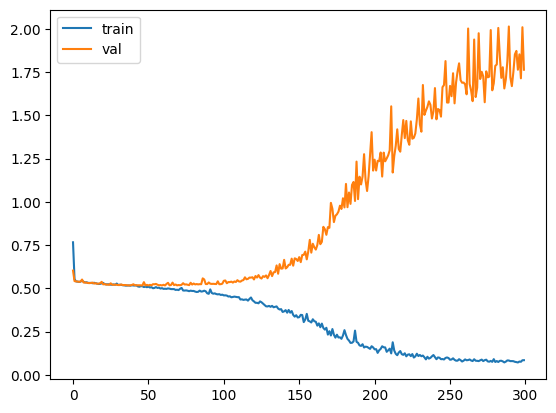

In [90]:
# plot the training and validation loss
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()


In [91]:
# get the accuracy of the model
correct = 0
total = 0
with torch.no_grad():
    for data, target in val_loader:
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target_indices).sum().item()
        
print(f"Accuracy: {correct / total:.5f}")

Accuracy: 0.76735


In [92]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for data, target in val_loader:
        data = data.unsqueeze(1)
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(target_indices.tolist())
        
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=lang_dict.values(), yticklabels=lang_dict.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [32, 1, 1, 42]

In [ ]:
class AcousticLSTMModel(nn.Module):
    def __init__(self, input_size=42, hidden_size=128, num_layers=2, num_classes=len(lang_dict)):
        super(AcousticLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)  # get batch size
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = AcousticLSTMModel()

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# set the model device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# train the model

n_epochs = 500
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        target_indices = torch.argmax(target, dim=1)
        data = data.unsqueeze(1)
        output = model(data)
        loss = criterion(output, target_indices)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    for data, target in val_loader:
        data = data.unsqueeze(1)
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        loss = criterion(output, target_indices)
        val_loss += loss.item() * data.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")


Epoch 1/500 Train Loss: 0.7480 Val Loss: 0.5475
Epoch 2/500 Train Loss: 0.5442 Val Loss: 0.5460
Epoch 3/500 Train Loss: 0.5410 Val Loss: 0.5450
Epoch 4/500 Train Loss: 0.5403 Val Loss: 0.5442
Epoch 5/500 Train Loss: 0.5407 Val Loss: 0.5437
Epoch 6/500 Train Loss: 0.5406 Val Loss: 0.5444
Epoch 7/500 Train Loss: 0.5391 Val Loss: 0.5443
Epoch 8/500 Train Loss: 0.5394 Val Loss: 0.5424
Epoch 9/500 Train Loss: 0.5391 Val Loss: 0.5420
Epoch 10/500 Train Loss: 0.5382 Val Loss: 0.5429
Epoch 11/500 Train Loss: 0.5386 Val Loss: 0.5423
Epoch 12/500 Train Loss: 0.5402 Val Loss: 0.5463
Epoch 13/500 Train Loss: 0.5418 Val Loss: 0.5461
Epoch 14/500 Train Loss: 0.5416 Val Loss: 0.5462
Epoch 15/500 Train Loss: 0.5416 Val Loss: 0.5458
Epoch 16/500 Train Loss: 0.5413 Val Loss: 0.5460
Epoch 17/500 Train Loss: 0.5418 Val Loss: 0.5452
Epoch 18/500 Train Loss: 0.5412 Val Loss: 0.5452
Epoch 19/500 Train Loss: 0.5412 Val Loss: 0.5458
Epoch 20/500 Train Loss: 0.5412 Val Loss: 0.5456
Epoch 21/500 Train Loss: 0.54

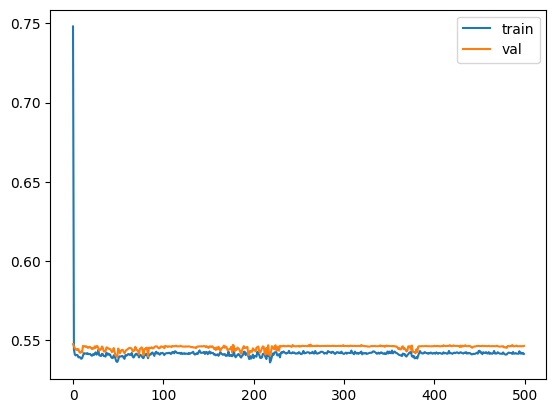

In [ ]:
# plot the training and validation loss
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()


In [ ]:
# get the accuracy
correct = 0
total = 0

with torch.no_grad():
    for data, target in val_loader:
        data = data.unsqueeze(1)
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target_indices).sum().item()
        
print(f"Accuracy: {correct / total:.2f}")

Accuracy: 0.84


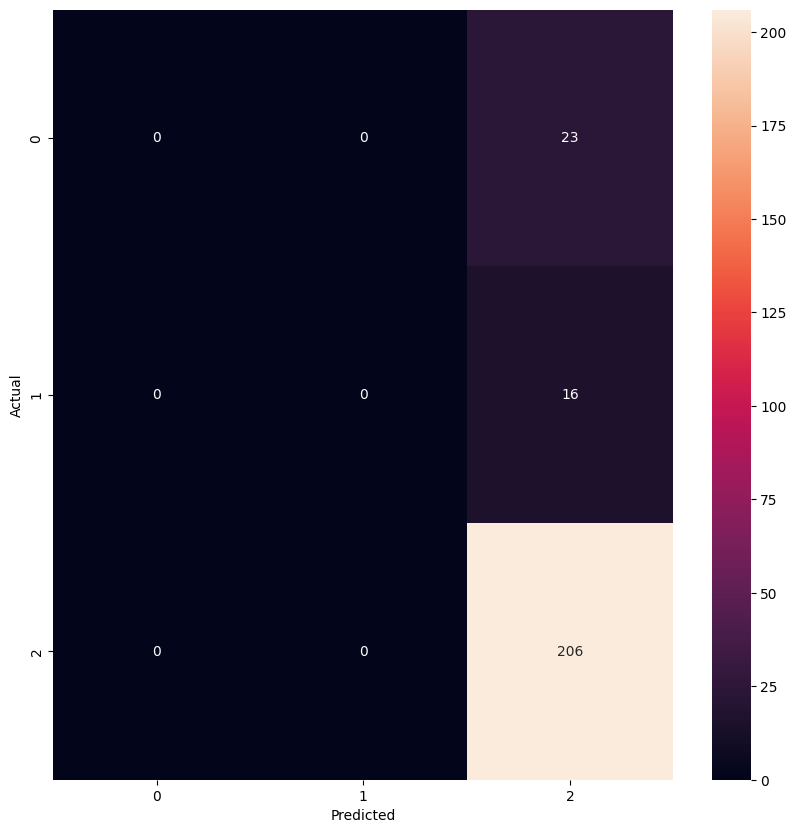

In [ ]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for data, target in val_loader:
        data = data.unsqueeze(1)
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(target_indices.tolist())
        
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=lang_dict.values(), yticklabels=lang_dict.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# create GRU model
class AcousticGRUModel(nn.Module):
    def __init__(self, input_size=42, hidden_size=128, num_layers=2, num_classes=len(lang_dict)):
        super(AcousticGRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)  # get batch size
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1])
        return out
    
model = AcousticGRUModel()

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# set the model device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

# train the model
n_epochs = 500
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        target_indices = torch.argmax(target, dim=1)
        data = data.unsqueeze(1)
        output = model(data)
        loss = criterion(output, target_indices)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    for data, target in val_loader:
        data = data.unsqueeze(1)
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        loss = criterion(output, target_indices)
        val_loss += loss.item() * data.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")
    

Epoch 1/500 Train Loss: 1.2194 Val Loss: 1.2157
Epoch 2/500 Train Loss: 1.2170 Val Loss: 1.2130
Epoch 3/500 Train Loss: 1.2143 Val Loss: 1.2102
Epoch 4/500 Train Loss: 1.2116 Val Loss: 1.2073
Epoch 5/500 Train Loss: 1.2088 Val Loss: 1.2045
Epoch 6/500 Train Loss: 1.2060 Val Loss: 1.2016
Epoch 7/500 Train Loss: 1.2031 Val Loss: 1.1986
Epoch 8/500 Train Loss: 1.2002 Val Loss: 1.1956
Epoch 9/500 Train Loss: 1.1972 Val Loss: 1.1926
Epoch 10/500 Train Loss: 1.1942 Val Loss: 1.1896
Epoch 11/500 Train Loss: 1.1911 Val Loss: 1.1865
Epoch 12/500 Train Loss: 1.1880 Val Loss: 1.1835
Epoch 13/500 Train Loss: 1.1849 Val Loss: 1.1805
Epoch 14/500 Train Loss: 1.1818 Val Loss: 1.1776
Epoch 15/500 Train Loss: 1.1788 Val Loss: 1.1747
Epoch 16/500 Train Loss: 1.1758 Val Loss: 1.1719
Epoch 17/500 Train Loss: 1.1729 Val Loss: 1.1692
Epoch 18/500 Train Loss: 1.1701 Val Loss: 1.1665
Epoch 19/500 Train Loss: 1.1675 Val Loss: 1.1640
Epoch 20/500 Train Loss: 1.1649 Val Loss: 1.1616
Epoch 21/500 Train Loss: 1.16

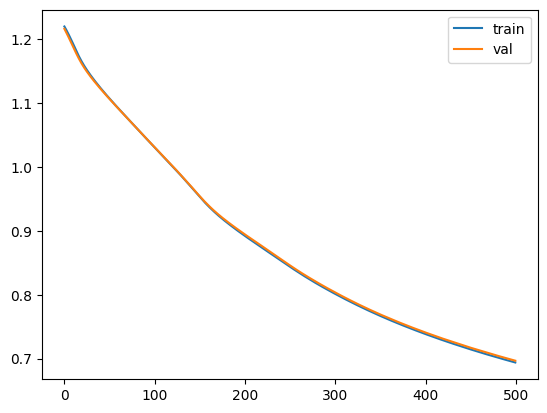

In [ ]:
# plot the training and validation loss
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

In [ ]:
# get the accuracy
correct = 0
total = 0

with torch.no_grad():
    for data, target in val_loader:
        data = data.unsqueeze(1)
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target_indices).sum().item()
        
print(f"Accuracy: {correct / total:.2f}")

Accuracy: 0.84


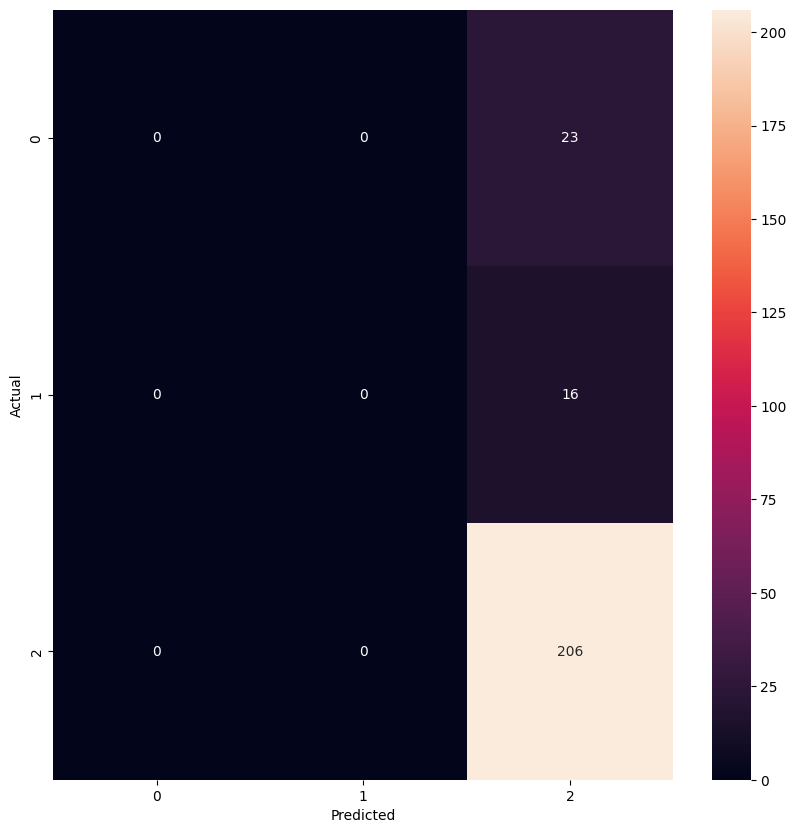

In [ ]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for data, target in val_loader:
        data = data.unsqueeze(1)
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(target_indices.tolist())
        
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=lang_dict.values(), yticklabels=lang_dict.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:

# build a CNN model

class AcousticCNNModel(nn.Module):
    def __init__(self, input_size=42, num_classes=len(lang_dict)):
        super(AcousticCNNModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, stride=2),
            nn.ReLU(),
        )
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.mean(-1)
        x = self.fc(x)
        return x
    
model = AcousticCNNModel()

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, eps=1e-3, weight_decay=.1)

# set the model device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# train the model

n_epochs = 500
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        optimizer.zero_grad()
        target_indices = torch.argmax(target, dim=1)
        data = data.unsqueeze(1)
        output = model(data)
        loss = criterion(output, target_indices)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    for data, target in val_loader:
        data = data.unsqueeze(1)
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        loss = criterion(output, target_indices)
        val_loss += loss.item() * data.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{n_epochs} Train Loss: {train_loss:.4f} Val Loss: {val_loss:.4f}")

Epoch 1/500 Train Loss: 0.8563 Val Loss: 0.5526
Epoch 2/500 Train Loss: 0.5509 Val Loss: 0.5603
Epoch 3/500 Train Loss: 0.5558 Val Loss: 0.5429
Epoch 4/500 Train Loss: 0.5490 Val Loss: 0.5653
Epoch 5/500 Train Loss: 0.5532 Val Loss: 0.5446
Epoch 6/500 Train Loss: 0.5531 Val Loss: 0.5396
Epoch 7/500 Train Loss: 0.5627 Val Loss: 0.5490
Epoch 8/500 Train Loss: 0.5456 Val Loss: 0.5447
Epoch 9/500 Train Loss: 0.5539 Val Loss: 0.5506
Epoch 10/500 Train Loss: 0.5491 Val Loss: 0.5745
Epoch 11/500 Train Loss: 0.5714 Val Loss: 0.5513
Epoch 12/500 Train Loss: 0.5563 Val Loss: 0.6440
Epoch 13/500 Train Loss: 0.5585 Val Loss: 0.5416
Epoch 14/500 Train Loss: 0.5430 Val Loss: 0.5560
Epoch 15/500 Train Loss: 0.5534 Val Loss: 0.5418
Epoch 16/500 Train Loss: 0.5492 Val Loss: 0.5438
Epoch 17/500 Train Loss: 0.5470 Val Loss: 0.5409
Epoch 18/500 Train Loss: 0.5523 Val Loss: 0.5445
Epoch 19/500 Train Loss: 0.5599 Val Loss: 0.5558
Epoch 20/500 Train Loss: 0.5523 Val Loss: 0.5403
Epoch 21/500 Train Loss: 0.54

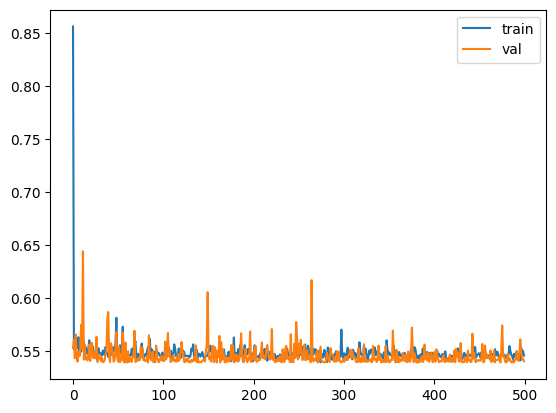

In [ ]:
# plot the training and validation loss
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

In [ ]:
# get the accuracy
correct = 0
total = 0

with torch.no_grad():
    for data, target in val_loader:
        data = data.unsqueeze(1)
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target_indices).sum().item()
        
print(f"Accuracy: {correct / total:.2f}")

Accuracy: 0.84


In [ ]:
lang_dict

{'uk': 0, 'canada': 1, 'usa': 2}

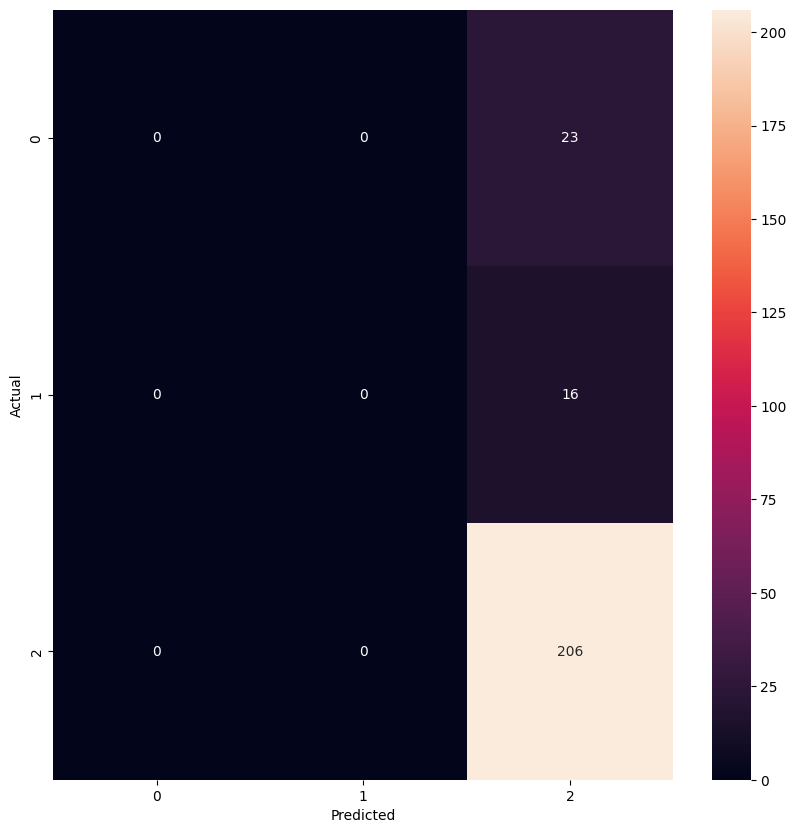

In [ ]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for data, target in val_loader:
        data = data.unsqueeze(1)
        target_indices = torch.argmax(target, dim=1)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(target_indices.tolist())
        
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=lang_dict.values(), yticklabels=lang_dict.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [ ]:
# # random undersampling of the majority classes
# rus = RandomUnderSampler(random_state=83, sampling_strategy='majority')
# y = native_bio_metadata[['label']]
# dd = native_bio_metadata.drop(['label'], axis=1)
# dd, y_resampled = rus.fit_resample(dd, y)
# del y
# dd['label'] = y_resampled
# del y_resampled
# # random oversampling of all minority classes
# y = dd[['label']]
# dd = dd.drop(['label'], axis=1)
# ros = RandomOverSampler(random_state=83)
# dd, y_resampled = ros.fit_resample(dd, y)
# del y
# dd['label'] = y_resampled
# del y_resampled
# gc.collect()